In [1]:
# Install densratio
# git clone https://github.com/hoxo-m/densratio_py.git

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from copy import deepcopy

import algorithms
import classifiers

# Dataset

In [3]:
data_option = "dataset1"

## Data generation

In [4]:
def dataset2(period=200, N_tot=1000):
    mu = 0
    sigma = 1.
    N = 1
    
    T = [0, 1]
    X = [np.random.normal(mu, sigma, 1)[0], np.random.normal(mu, sigma, 1)[0]]
    
    for i in range(2, N_tot):
        if i % period == 0:
            N += 1
        if N % 2 == 1:
            sigma = 1
        if N % 2 == 0:
            sigma = 1 + 0.25 * N#np.log(np.e + N / 1.)
        T += [i]
        ax = 0.6 * X[i-1] - 0.5 * X[i-2] + np.random.normal(mu, sigma, 1)[0]
        X += [ax] 
    return np.array(X).reshape(-1, 1)


def dataset1(period=200, N_tot=1000):
    mu = 0
    sigma = 1.
    N = 1
    
    T = [0, 1]
    X = [np.random.normal(mu, sigma, 1)[0], np.random.normal(mu, sigma, 1)[0]]
    
    for i in range(2, N_tot):
        if i % period == 0:
            N += 1
            mu += 0.5 * N
        T += [i]
        ax = 0.6 * X[i-1] - 0.5 * X[i-2] + np.random.normal(mu, sigma, 1)[0]
        X += [ax]
    return np.array(X).reshape(-1, 1)


def dataset3(period=200, N_tot=1000):
    mu = 0
    sigma = 1.
    N = 1
    
    T = [0, 1]
    X = [np.random.multivariate_normal(mean=[0, 0], cov=[[1, -0.8], [-0.8, 1]], size=1)[0], 
         np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.8],  [ 0.8, 1]], size=1)[0]]
    
    for i in range(2, N_tot):
        if i % period == 0:
            N += 1
        if N % 2 == 1:
            cov = [[1, -0.8-0.002*N], [-0.8-0.002*N, 1]]
            #cov = [[1, -0.95], [-0.95, 1]]
        if N % 2 == 0:
            cov = [[1, 0.8+0.002*N], [0.8+0.002*N, 1]]
            #cov = [[1, 0.95], [0.95, 1]]
        T += [i]
        ax = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1)[0]
        X += [ax]
    return np.array(X)


def dataset4(period=200, N_tot=1000):
    mu = 0
    sigma = 0.8
    w = 1.
    N = 1
    
    T = [0, 1]
    X = [np.sin(w * 0) + np.random.normal(0, 0.5, 1), 
         np.sin(w * 1) + np.random.normal(0, 0.5, 1)]
    
    for i in range(2, N_tot):
        if i % period == 0:
            N += 1
            w = w * np.log(np.e + 0.5 * N)
        T += [i]
        ax = np.sin(w * i) + np.random.normal(0, 0.5, 1)
        X += [ax]
    return np.array(X).reshape(-1, 1)

In [5]:
if data_option == "dataset1":
    N_tot = 20000
    X = [dataset1(period=2000, N_tot=N_tot) for i in range(10)]
    X = np.vstack(tuple(X))
    T = np.arange(len(X))
    R1 = 5 * np.random.normal(0, 1, len(X)).reshape(-1, 1)
    X = np.hstack((X, R1))

if data_option == "dataset2":
    N_tot = 20000
    X = [dataset2(period=2000, N_tot=N_tot) for i in range(10)]
    X = np.vstack(tuple(X))
    T = np.arange(len(X))
    R1 = 5 * np.random.normal(0, 1, len(X)).reshape(-1, 1)
    X = np.hstack((X, R1))
    
if data_option == "dataset3":
    N_tot = 20000
    X = [dataset3(period=2000, N_tot=N_tot) for i in range(1)]
    X = np.vstack(tuple(X))
    T = np.arange(len(X))
    R1 = 5 * np.random.normal(0, 1, len(X)).reshape(-1, 1)
    #X = np.hstack((X, R1))
    
if data_option == "dataset4":
    N_tot = 20000
    X = [dataset4(period=2000, N_tot=N_tot) for i in range(10)]
    X = np.vstack(tuple(X))
    T = np.arange(len(X))
    R1 = 1 * np.random.normal(0, 1, len(X)).reshape(-1, 1)
    #X = np.hstack((X, R1))

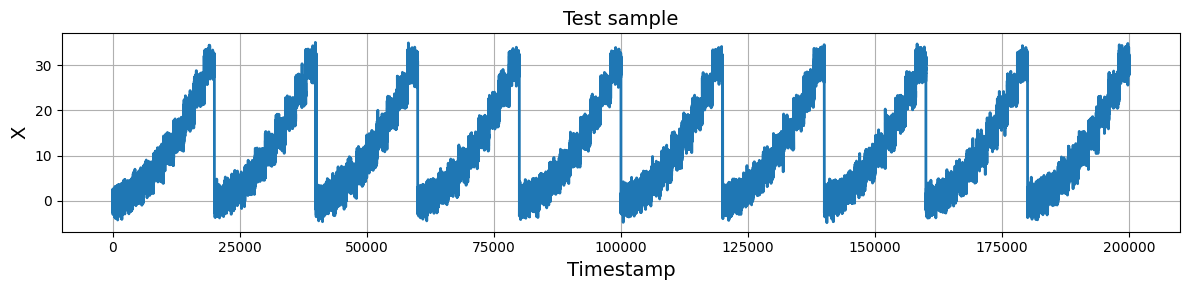

In [6]:
# Display test sample
plt.figure(figsize=(12, 3.))
plt.plot(T, X[:, 0], linewidth=2)
plt.xlabel('Timestamp', size=14)
plt.ylabel('X', size=14)
plt.grid(True)
plt.title('Test sample', size=14)
plt.tight_layout()
plt.show()

## Change point detection

In [7]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

In [8]:
periods = 10
window_size = 500
step = 10
n_runs = 1


rulsif = algorithms.ChangePointDetectionRuLSIF(alpha=0.1, 
                                               sigma_range=[10.], # [0.1, 1., 10.], 
                                               lambda_range=[0.01], # [0.01, 0.1, 1.], 
                                               kernel_num=10,
                                               metric="PE", 
                                               periods=periods, 
                                               window_size=window_size, 
                                               step=step, 
                                               n_runs=1)



nn_base_classifier = classifiers.FitMyNN(n_hidden=10, dropout=0., n_epochs=20, batch_size=32, lr=0.1, 
                                         lam=0.0, optimizer="Adam", debug=0)
nn_classifier = algorithms.ChangePointDetectionClassifier(base_classifier=nn_base_classifier, 
                                                          metric="KL_sym", 
                                                          periods=periods, 
                                                          window_size=window_size, 
                                                          step=step, 
                                                          n_runs=1)


#gbdt_base_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, max_depth=6)
gbdt_base_classifier = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, verbosity=0, subsample=0.8)
gbdt_classifier = algorithms.ChangePointDetectionClassifier(base_classifier=gbdt_base_classifier, 
                                                            metric="KL_sym", 
                                                            periods=periods, 
                                                            window_size=window_size, 
                                                            step=step, 
                                                            n_runs=1)


qda_base_classifier = QuadraticDiscriminantAnalysis()
qda_classifier = algorithms.ChangePointDetectionClassifier(base_classifier=qda_base_classifier, 
                                                          metric="KL_sym", 
                                                          periods=periods, 
                                                          window_size=window_size, 
                                                          step=step, 
                                                          n_runs=1)


base_classifier2 = classifiers.FitMyNN_RuLSIF(n_hidden=10, dropout=0., n_epochs=20, batch_size=32, lr=0.1, 
                                              lam=0., alpha=0.1, optimizer="Adam", debug=0)
nn_rulsif = algorithms.ChangePointDetectionClassifier_RuLSIF(base_classifier=base_classifier2, metric="PE", 
                                                             periods=periods, 
                                                             window_size=window_size, 
                                                             step=step, 
                                                             n_runs=1)



base_classifier21 = classifiers.GBDTRulSIF(n_estimators=100, learning_rate=0.2, sample_frac=0.8, alpha=0.1, 
                                           max_depth=4, min_samples_leaf=1)
gbdt_rulsif = algorithms.ChangePointDetectionClassifier_RuLSIF(base_classifier=base_classifier21, metric="PE", 
                                                               periods=periods, 
                                                               window_size=window_size, 
                                                               step=step, 
                                                               n_runs=1)

In [9]:
print('RuLSIF')
%time T_score_rulsif, score_rulsif = deepcopy(rulsif).predict(X)

print('NN')
%time T_score_nn_classifier, score_nn_classifier = deepcopy(nn_classifier).predict(X)

print('QDA')
%time T_score_qda_classifier, score_qda_classifier = deepcopy(qda_classifier).predict(X)

print('GBDT')
%time T_score_gbdt_classifier, score_gbdt_classifier = deepcopy(gbdt_classifier).predict(X)

print('NN-RuLSIF')
%time T_score_nn_rulsif, score_nn_rulsif = deepcopy(nn_rulsif).predict(X)

print('GBDT-RuLSIF')
%time T_score_gbdt_rulsif, score_gbdt_rulsif = deepcopy(gbdt_rulsif).predict(X)

RuLSIF


KeyboardInterrupt: 

NN


## Visualization

In [ ]:
def get_label(T, period=2000, window_size=500):
    S = np.zeros(len(T))
    S[(T % period < 2 * window_size) & (T // period > 0)] = 1
    return S

def new_score(score):
    score_new = [score[0]]
    for i in range(1, len(score)):
        score_new += [max(0, score_new[-1] + score[i])]
    return np.array(score_new)

In [ ]:
score_rulsif = np.nan_to_num(score_rulsif)
score_nn_classifier = np.nan_to_num(score_nn_classifier)
score_gbdt_classifier = np.nan_to_num(score_gbdt_classifier)
score_qda_classifier = np.nan_to_num(score_qda_classifier)
score_nn_rulsif = np.nan_to_num(score_nn_rulsif)
score_gbdt_rulsif = np.nan_to_num(score_gbdt_rulsif)

In [ ]:
S = get_label(T, period=2000, window_size=500)

## Saving

In [ ]:
# Save data
df = pd.DataFrame()
df['T'] = T
df['S'] = S
for i in range(X.shape[1]):
    df["X"+str(i)] = X[:, i]
df.to_csv("results/"+data_option+"_data.csv", index=False)

# Save models outputs
df = pd.DataFrame()
df['T'] = T_score_rulsif
df['S'] = S[T_score_rulsif]
df['Score'] = score_rulsif
df.to_csv("results/"+data_option+"_RuLSIF.csv", index=False)

df = pd.DataFrame()
df['T'] = T_score_nn_classifier
df['S'] = S[T_score_nn_classifier]
df['Score'] = score_nn_classifier
df.to_csv("results/"+data_option+"_NN.csv", index=False)

df = pd.DataFrame()
df['T'] = T_score_gbdt_classifier
df['S'] = S[T_score_gbdt_classifier]
df['Score'] = score_gbdt_classifier
df.to_csv("results/"+data_option+"_GBDT.csv", index=False)

df = pd.DataFrame()
df['T'] = T_score_qda_classifier
df['S'] = S[T_score_qda_classifier]
df['Score'] = score_qda_classifier
df.to_csv("results/"+data_option+"_QDA.csv", index=False)

df = pd.DataFrame()
df['T'] = T_score_nn_rulsif
df['S'] = S[T_score_nn_rulsif]
df['Score'] = score_nn_rulsif
df.to_csv("results/"+data_option+"_NN_RuLSIF.csv", index=False)

df = pd.DataFrame()
df['T'] = T_score_gbdt_rulsif
df['S'] = S[T_score_gbdt_rulsif]
df['Score'] = score_gbdt_rulsif
df.to_csv("results/"+data_option+"_GBDT_RuLSIF.csv", index=False)

In [ ]:
# Display test sample
plt.figure(figsize=(12, 3.))
plt.plot(T, X, linewidth=2)
plt.xlabel('Timestamp', size=14)
plt.ylabel('X', size=14)
plt.grid(True)
plt.title('Test sample', size=14)
plt.tight_layout()
plt.show()


# Display test sample
plt.figure(figsize=(12, 3.))
plt.plot(T_score_rulsif, score_rulsif, linewidth=3, label="RuLSIF")
plt.plot(T_score_nn_classifier, score_nn_classifier, linewidth=3, label="NN")
plt.plot(T_score_gbdt_classifier, score_gbdt_classifier, linewidth=3, label="GBDT")
plt.plot(T_score_qda_classifier, score_qda_classifier, linewidth=3, label="QDA")
plt.plot(T_score_nn_rulsif, score_nn_rulsif, linewidth=3, label="NN-RuLSIF")
plt.plot(T_score_gbdt_rulsif, score_gbdt_rulsif, linewidth=3, label="GBDT-RuLSIF")

plt.xlabel('Timestamp', size=14)
plt.ylabel('X', size=14)
plt.grid(True)
plt.title('Change point detection score', size=14)
plt.legend(loc='best')
plt.tight_layout()
#plt.ylim(-0.2, 10.)
plt.show()

In [ ]:
# Display test sample
plt.figure(figsize=(12, 3.))
plt.plot(T, X[:, 0], linewidth=2)
plt.plot(T, S, linewidth=2)
plt.xlabel('Timestamp', size=14)
plt.ylabel('X', size=14)
plt.grid(True)
plt.title('Test sample', size=14)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(S[T_score_rulsif], score_rulsif)
auc = roc_auc_score(S[T_score_rulsif], score_rulsif)
plt.plot(fpr, tpr, label='RuLSIF', linewidth=3)
print("RuLSIF: ", auc)

fpr, tpr, _ = roc_curve(S[T_score_nn_classifier], score_nn_classifier)
auc = roc_auc_score(S[T_score_nn_classifier], score_nn_classifier)
plt.plot(fpr, tpr, label='NN', linewidth=3)
print("NN: ", auc)

fpr, tpr, _ = roc_curve(S[T_score_qda_classifier], score_qda_classifier)
auc = roc_auc_score(S[T_score_qda_classifier], score_qda_classifier)
plt.plot(fpr, tpr, label='QDA', linewidth=3)
print("QDA: ", auc)

fpr, tpr, _ = roc_curve(S[T_score_gbdt_classifier], score_gbdt_classifier)
auc = roc_auc_score(S[T_score_gbdt_classifier], score_gbdt_classifier)
plt.plot(fpr, tpr, label='GBDT', linewidth=3)
print("GBDT: ", auc)

fpr, tpr, _ = roc_curve(S[T_score_nn_rulsif], score_nn_rulsif)
auc = roc_auc_score(S[T_score_nn_rulsif], score_nn_rulsif)
plt.plot(fpr, tpr, label='NN-RuLSIF', linewidth=3)
print("NN-RuLSIF: ", auc)

fpr, tpr, _ = roc_curve(S[T_score_gbdt_rulsif], score_gbdt_rulsif)
auc = roc_auc_score(S[T_score_gbdt_rulsif], score_gbdt_rulsif)
plt.plot(fpr, tpr, label='GBDT-RuLSIF', linewidth=3)
print("GBDT-RuLSIF: ", auc)


plt.legend(loc='best')
#plt.ylim(0.5, 1.)
plt.show()